# Latent Force Models

In this note we present the latent force model first in its mathematical form as a state space model, before discussing how [1] embedded some mathematical structure into these models creating an appealing class of hybrid models for dynamical systems. 

Along the way we will begin to introduce the basic classes. For a guide to simulating from this model and fitting observations see the notebook `ref`.
 
 A latent force model describes the evolution of a $K$ dimensional state vector taking values in $\mathbb{R}^{K}$. The LFM is described by the system of ordinary differential equations (ODE)
 
 $$
 \dot{x}_k(t) + D_k x(t) = \sum_{r=1}^{R} f_r(t) + B_k, \qquad k=1,\ldots, K.
 $$
 
 Such a system is easily solved, with the formal solution given by
 
 $$
 x_k(t) = e^{-D_k(t-t_0)}x_k(t_0) + \int_{t_0}^t e^{-D_k(t-\tau)}\left(\sum_{r=1}^R f_r(\tau) + B_k \right) d\tau.
 $$
 
 Such systems occur frequently in mathematics, and indeed as a mathematical object the LFM will be well familiar to engineers and those with knowledge of control theory where this system is an example of a *linear time invariant* system.

One feature that is apparent from the system of ODEs above is that the state variables interact with one another only through the shared set of latent forces.

### Necessary Imports

Apart from the LFM package itself we will use

1. `numpy` --- because where would we be without it?
2. `matplotlib` --- for visualisation
3. `scipy.integrate.odeint` --- solve the ODE numerically
4. `tensorflow` --- learning to love it


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import tensorflow as tf

from lfm_flow.mogaussianprocesses import MultioutputGaussianProcess
from lfm_flow.mogaussianprocesses import MultioutputGaussianProcessRegressionModel
from lfm_flow.kernels import LFM1_RBF

np.random.seed(123)  # reproducability!


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Example using ODE int

This will also allow us to demonstrate the batching of the LFM models. A batch from a TensorFlow Probability distribution represents a collection of independent, non-identically, distributed random variables. We demonstrate this below using the sensitivity matrix, any particular instance of the LFM requires a single $K \times R$ matrix to parameterise it. To create a batched version of the LFM we ensure the parameters have shape `[b1,...,bB, K, R]` -- in the simple example below we have `D.shape = [2, K]` so that the batch shape will have shape `(2, )`.

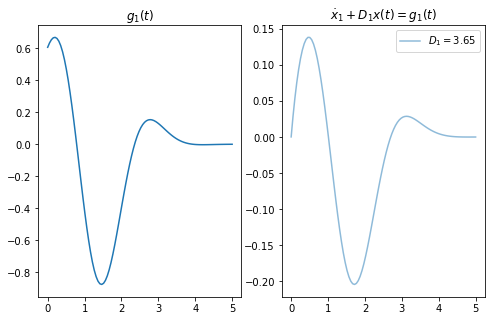

In [2]:
K = 2 # Dimension of the state variable
R = 1 # No. of latent forces

d1 = np.linspace(-0.4, 5., 5)
d1 = np.array([d1[3]])
D = np.column_stack((d1, 0.3*np.ones(d1.size)))

S = np.array([[ 1.],
              [ 1.]])

# true latent force, an RBF weighted sinusoidal force
g = lambda t: np.exp(-.5*(t-1.)**2) * np.cos(2*t)

# initial conditions are 0
x0 = [0., 0.]

def dXdt(X, t, D, Sensmat):
    return -np.diag(D).dot(X) + (Sensmat * g(t)).ravel()

# dense set of time points for simulation
ttd = np.linspace(0., 5., 100)
sols = [odeint(dXdt, x0, ttd, args=(_d, S))
        for _d in D]

N1 = 5 # no. of obs from x1(t)
N2 = 3 # no. of obs from x2(t)

ind1 = np.sort(np.random.choice(ttd.size-1, replace=False, size=N1))
#ind1 = np.linspace(0, ttd.size-1, N1, dtype=np.intp)
ind2 = np.sort(np.random.choice(ttd.size-1, replace=False, size=N2))
#ind2 = np.linspace(0, ttd.size-1, N2, dtype=np.intp)
Ydat = np.concatenate([sols[0][ind1, 0],
                       sols[0][ind2, 1]])
#Ydat = np.concatenate([sol0[ind1, 0], sol0[ind2, 1]])
index_points = [ttd[ind1][:, None], 
                ttd[ind2][:, None]]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((8, 5))
ax1.plot(ttd, g(ttd), 'C0-')
ax1.set_title(r'$g_1(t)$')

for d, sol in zip(d1, sols):
    ax2.plot(ttd, sol[:, 0], '-', alpha=0.5,
             label=r'$D_1 = {:04.2f}$'.format(d))
ax2.legend(loc='upper right')
ax2.set_title(r'$\dot{x}_1 + D_1 x(t) = g_1(t)$')
plt.show()

## Probabilistic Model

In the control theory setting once often starts with certain desirable properties of the states of this system, and then attempts to introduce a control that achieves this goal. Alvarez et. al invert this process by asking given a particular history of states, what configuration of controls could have achieved such a system. By allowing the controls to have a Gaussian process distribution one realises a very flexible model exhibiting interesting dynamical systems properties.

We assume that each of the latent forces is given an indepenent Gaussian process prior

$$
f_r(t) \sim \mathcal{GP}(0, k_r(t, t')), \qquad r = 1,\ldots, R.
$$

In [3]:

def reset_session():
  """Creates a new global, interactive session in Graph-mode."""
  global sess
  try:
    tf.reset_default_graph()
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()



In [4]:
from lfm_flow.mogaussianprocesses import MultioutputGaussianProcess
from lfm_flow.kernels import LFM1_RBF

reset_session()

lf_length_scale = (np.finfo(np.float64).tiny +
                   tf.nn.softplus(tf.Variable(initial_value=(.5, ),
                                              name='lf_length_scale',

                                              dtype=np.float64)))

D_tensor = tf.get_variable(name='D', dtype=np.float64,
                           initializer=D)

kern = LFM1_RBF(D_tensor, S, lf_length_scale)

lfm = MultioutputGaussianProcess(kern, index_points, jitter=1e-6)

# Check our batch shape is behaving as expected
print(kern._batch_shape())


Instructions for updating:
Colocations handled automatically by placer.
(1,)


To sample some realisations from this random variable we now simply call the `sample` method. This will return a tensor of size 
```
>>> rv = lfm.sample(nsample) 
>>> rv.shape 
>>> # outputs [nsample, b1,...,bB, N1 + ... + NK]
```

In [5]:
Y = tf.placeholder(name='Y', dtype=np.float64, shape=(N1+N2, ))
log_likelihood = lfm.log_prob(Y)


In [6]:
# Define the optimization ops for maximizing likelihood (minimizing neg
# log-likelihood!)
optimizer = tf.train.AdamOptimizer(learning_rate=.01)
train_op = optimizer.minimize(-log_likelihood)

Instructions for updating:
Use tf.cast instead.


In [7]:
feed_dict = {Y: Ydat}

# Now we optimize the model parameters.
num_iters = 1000
# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
sess.run(tf.global_variables_initializer())
for i in range(num_iters):
  _, lls_[i] = sess.run([train_op, log_likelihood], feed_dict=feed_dict)

Values of D from max. likelihood
[[3.67700966 0.32957187]]
True values of D
[[3.65 0.3 ]]


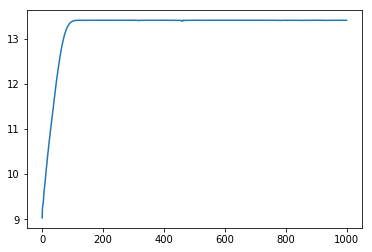

In [8]:
fig, ax = plt.subplots()
ax.plot(lls_)
Dval, Sval, lscales_val = sess.run(kern.variables)
print("Values of D from max. likelihood")
print(Dval)
print("True values of D")
print(D)
plt.show()

In [9]:
rv = lfm.sample(10)

rv = tf.split(rv, [N1, N2], axis=-1)
sess.run(tf.global_variables_initializer())
rv = sess.run(rv)

So we have no successfully sample some trajectories from our LFM, these are all ready to use once we have initialised the tensorflow graphs and variables.

In [10]:

t1, t2 = index_points
X1, X2 = rv
print(X1.shape)
#fig, ax = plt.subplots()
#ax.plot(t1, X1[3, 0, :].T, '+-')
#plt.show()

(10, 1, 5)


In [11]:
Y = tf.placeholder(name='Y', dtype=np.float64, shape=(N1+N2, ))
predict_index_points = [ttd[:, None], ttd[:, None]]

gprm = MultioutputGaussianProcessRegressionModel(
    kern,
    index_points=predict_index_points,
    observation_noise_variance=0.0,
    observation_index_points=index_points,
    observations=Y,
    jitter=1e-6)

samples = gprm.sample(10, seed=123)
#print(samples.shape)
#samples = tf.split(samples, gprm.index_points_shape, axis=-1)

In [12]:

#_y += np.random.normal(size=_y.size, scale=0.0)
samples = sess.run(samples, feed_dict={Y: Ydat})

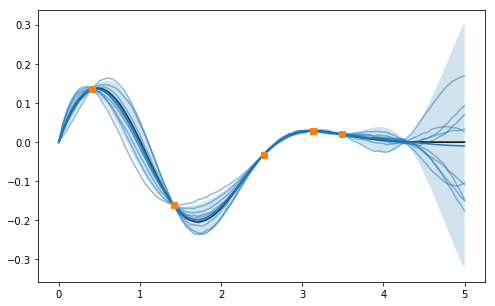

In [13]:
mean = tf.split(gprm.loc, gprm.index_points_shape, axis=-1)
mean = sess.run(mean, feed_dict={Y: Ydat})
covar = sess.run(gprm._covariance_matrix)
var = np.diag(covar[0, ...])
sd = np.sqrt(var)[:ttd.size]

fig, ax = plt.subplots()
fig.set_size_inches((8, 5))

ax.plot(ttd, sols[0][:, 0], 'k-')
ax.plot(ttd, samples[0][:, 0, :].T, 'C0-', alpha=0.5)

ax.plot(ttd, mean[0][0, :])
ax.fill_between(ttd, 
                mean[0][0, :] + 2*sd,
                mean[0][0, :] - 2*sd, alpha=0.2)

ax.plot(ttd[ind1], Ydat[:N1], 'C1s')


#ax.plot(ttd, sol0[:, 0], 'k-')
#ax.plot(ttd[ind1], Ydat[:N1], 'C1s', markersize=9)
#ax.plot(ttd[ind1], sol0[ind1, 0], 'C3o')


plt.show()